In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import time
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report



/home/aimsgh-28/.local/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# KUMASI

In [21]:
# Load the dataset
data= pd.read_csv('KUMASI.csv')
df = pd.DataFrame(data)
df.head()

,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches)
0,1973-01-04,80,88.0,73.0,NaN
1,1973-01-06,82,NaN,NaN,NaN
2,1973-01-19,81,91.0,NaN,NaN
3,1973-01-21,77,NaN,63.0,NaN
4,1973-01-26,83,NaN,72.0,NaN


In [22]:
df.describe()

,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches)
count,5436.000000,3428.000000,3676.000000,2185.000000
mean,79.856144,88.910152,72.599293,0.279465
std,3.439837,4.485307,2.444528,0.819855
min,66.000000,74.000000,56.000000,0.000000
25%,77.000000,86.000000,71.000000,0.000000
50%,80.000000,89.000000,72.000000,0.000000
75%,82.000000,92.000000,74.000000,0.240000
max,95.000000,103.000000,80.000000,18.560000


In [23]:

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' column as the index
df = df.set_index('Date')

# Create a new DataFrame with a complete date range
complete_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
complete_df = pd.DataFrame(index=complete_dates)

# Merge original DataFrame with complete DataFrame
merged_df = complete_df.merge(df, left_index=True, right_index=True, how='left')

# Forward fill missing values
#filled_df = merged_df.fillna(method='ffill')

# Reset the index
merged_df = merged_df.reset_index()

# Rename columns
merged_df.columns = ['Date', 'TAVG (Degrees Fahrenheit)','TMAX (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)','PRCP (Inches)']

# Output the filled DataFrame
kumasi=merged_df
kumasi.shape
kumasi.head()



#Changing strings to float
kumasi['TAVG (Degrees Fahrenheit)'] = kumasi['TAVG (Degrees Fahrenheit)'].astype(float)
kumasi['TMAX (Degrees Fahrenheit)'] = kumasi['TMAX (Degrees Fahrenheit)'].astype(float)
kumasi['TMIN (Degrees Fahrenheit)'] = kumasi['TMIN (Degrees Fahrenheit)'].astype(float)
kumasi['PRCP (Inches)']=kumasi['PRCP (Inches)'].astype(float)

df_copy = kumasi.copy()
#delete date
column_to_delete = ['TAVG (Degrees Fahrenheit)','TMAX (Degrees Fahrenheit)','TMIN (Degrees Fahrenheit)']
df_copy.drop(columns=column_to_delete, inplace=True)
#df_copy.tail(70)


# Set values to 0 for rows with months 11, 12, 01, 02, and 03
df_copy.loc[df_copy['Date'].dt.month.isin([11, 12, 1, 2]), 'PRCP (Inches)'] = 0

del kumasi['PRCP (Inches)']

kumasi = pd.merge(kumasi, df_copy, on='Date')

# Impute categorical var with Mode
kumasi['MIN_TEMP_DF'] = kumasi['TMIN (Degrees Fahrenheit)'].fillna(kumasi['TMIN (Degrees Fahrenheit)'].mode()[0])
kumasi['MAX_TEMP_DF'] = kumasi['TMAX (Degrees Fahrenheit)'].fillna(kumasi['TMAX (Degrees Fahrenheit)'].mode()[0])
kumasi['AVG_TEMP_DF'] = kumasi['TAVG (Degrees Fahrenheit)'].fillna(kumasi['TAVG (Degrees Fahrenheit)'].mode()[0])
kumasi['PRCP (In)'] = kumasi['PRCP (Inches)'].fillna(kumasi['PRCP (Inches)'].mode()[0])

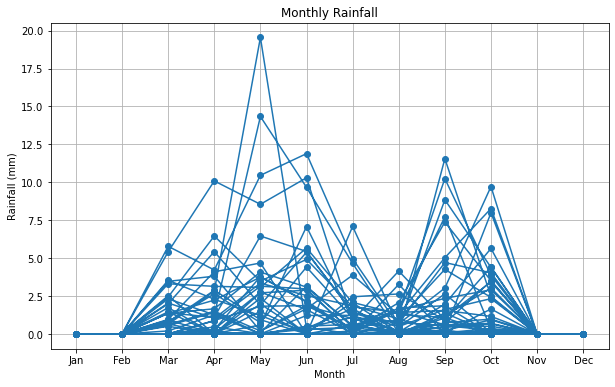

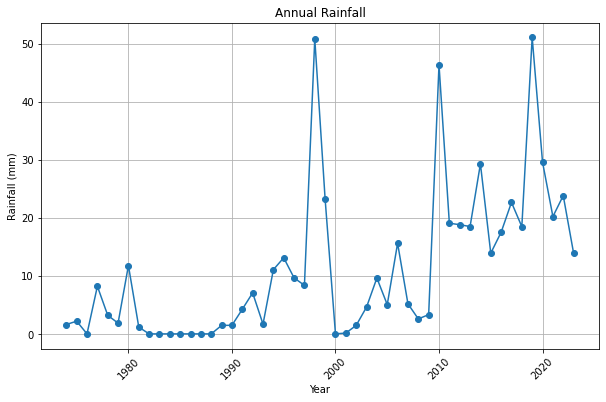

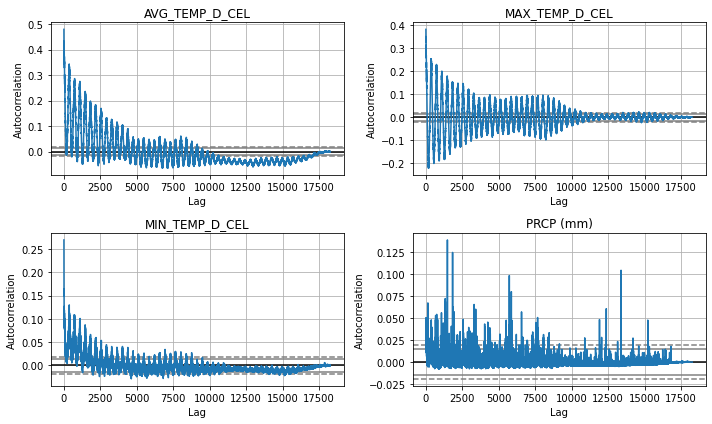

AVG_TEMP_D_CEL    0.479439
MAX_TEMP_D_CEL    0.381016
MIN_TEMP_D_CEL    0.269876
PRCP (mm)         0.041786
dtype: float64


<AxesSubplot:>

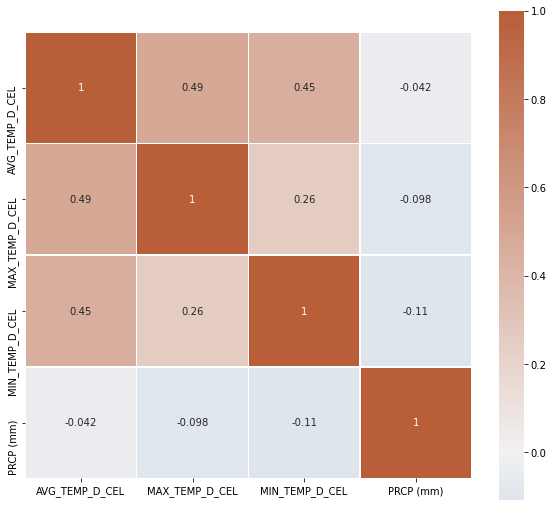

In [24]:
#Chaning temp. to degrees and iches to mm
kumasi["AVG_TEMP_D_CEL"] = (kumasi["AVG_TEMP_DF"] - 32) * 5/9
kumasi["MAX_TEMP_D_CEL"] = (kumasi["MAX_TEMP_DF"] - 32) * 5/9
kumasi["MIN_TEMP_D_CEL"] = (kumasi["MIN_TEMP_DF"] - 32) * 5/9
kumasi["PRCP (mm)"]=(kumasi["PRCP (In)"])*25.4

# Convert the 'Date' column to a datetime object
kumasi['Date'] = pd.to_datetime(kumasi['Date'])

# Set the 'Date' column as the DataFrame index
kumasi.set_index('Date', inplace=True)

# Resample the data to monthly and annual rainfall
monthly_rainfall = kumasi['PRCP (In)'].resample('M').sum()
annual_rainfall = kumasi['PRCP (In)'].resample('Y').sum()

# Plot monthly rainfall
plt.figure(figsize=(10, 6))
plt.plot(monthly_rainfall.index.month, monthly_rainfall.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Rainfall (mm)')
plt.title('Monthly Rainfall')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

# Plot annual rainfall
plt.figure(figsize=(10, 6))
plt.plot(annual_rainfall.index, annual_rainfall.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.title('Annual Rainfall')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Delete unwanted columns
delete = ['TAVG (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)','TMIN (Degrees Fahrenheit)','PRCP (Inches)','MIN_TEMP_DF', 'MAX_TEMP_DF', 'AVG_TEMP_DF', 'PRCP (In)'  ]
kumasi.drop(columns=delete, inplace=True)
                                                                        
kumasi=kumasi.round(2)

kumasi = pd.DataFrame(kumasi)

# Plot autocorrelation for each variable
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
axes = axes.flatten()

for i, col in enumerate(kumasi.columns):
    pd.plotting.autocorrelation_plot(kumasi[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


autocorr_results = kumasi.apply(lambda x: x.autocorr())

# Output autocorrelation results
print(autocorr_results)


corr = kumasi.corr()
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

In [25]:
#sns.pairplot( data=kumasi, vars=('AVG_TEMP_D_CEL','MAX_TEMP_D_CEL','MIN_TEMP_D_CEL'), hue='PRCP (mm)' )

In [26]:
kumasi.head()

,AVG_TEMP_D_CEL,MAX_TEMP_D_CEL,MIN_TEMP_D_CEL,PRCP (mm)
Date,,,,
1973-01-04,26.67,31.11,22.78,0.0
1973-01-05,25.56,32.22,22.22,0.0
1973-01-06,27.78,32.22,22.22,0.0
1973-01-07,25.56,32.22,22.22,0.0
1973-01-08,25.56,32.22,22.22,0.0


In [27]:
kumasi.describe()

,AVG_TEMP_D_CEL,MAX_TEMP_D_CEL,MIN_TEMP_D_CEL,PRCP (mm)
count,18259.000000,18259.000000,18259.000000,18259.000000
mean,25.865693,32.106708,22.287431,0.769044
std,1.143464,1.104949,0.623660,6.902728
min,18.890000,23.330000,13.330000,0.000000
25%,25.560000,32.220000,22.220000,0.000000
50%,25.560000,32.220000,22.220000,0.000000
75%,25.560000,32.220000,22.220000,0.000000
max,35.000000,39.440000,26.670000,471.420000


In [28]:
def convert_column_to_binary(data, column_name, threshold):
    data[column_name] = data[column_name].apply(lambda x: 1 if x >= threshold else 0)
    return data

data = kumasi

threshold = 0.8
column_name = 'PRCP (mm)'

data = convert_column_to_binary(data, column_name, threshold)

In [29]:
kumasi.head()

,AVG_TEMP_D_CEL,MAX_TEMP_D_CEL,MIN_TEMP_D_CEL,PRCP (mm)
Date,,,,
1973-01-04,26.67,31.11,22.78,0
1973-01-05,25.56,32.22,22.22,0
1973-01-06,27.78,32.22,22.22,0
1973-01-07,25.56,32.22,22.22,0
1973-01-08,25.56,32.22,22.22,0


<function matplotlib.pyplot.show(close=None, block=None)>

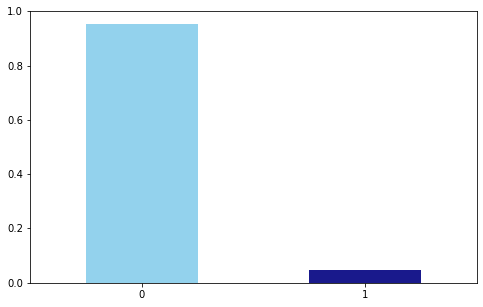

In [30]:
fig = plt.figure(figsize = (8,5))
kumasi['PRCP (mm)'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.show

In [31]:
# Separate features (X) and target variable (y)
X = data.drop('PRCP (mm)', axis=1)  # Adjust 'target_variable' with the name of your target variable column
y = data['PRCP (mm)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine X_train and y_train into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Separate the majority and minority classes
majority_class = train_data[train_data['PRCP (mm)'] == 0]
minority_class = train_data[train_data['PRCP (mm)'] == 1]

# Upsample the minority class
minority_upsampled = resample(minority_class,
                              replace=True,  # Sample with replacement
                              n_samples=len(majority_class),  # Match the majority class samples
                              random_state=42)

# Downsample the majority class
majority_downsampled = resample(majority_class,
                                replace=False,  # No replacement
                                n_samples=len(minority_class),  # Match the minority class samples
                                random_state=42)

# Combine the upsampled minority class with the downsampled majority class
balanced_data = pd.concat([majority_downsampled, minority_upsampled])


data=balanced_data

In [32]:

# Split the data into input features (X) and target variable (y)
X = data.drop('PRCP (mm)', axis=1)  # Assuming 'rainfall_occurrence' is the target variable
y = data['PRCP (mm)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the input features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


## Neural Network

In [45]:
class RainfallModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RainfallModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Define the model architecture and hyperparameters
input_size = X_train_tensor.shape[1]
hidden_size = 64
model = RainfallModel(input_size, hidden_size)


In [46]:
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [47]:
# Set the number of training epochs
num_epochs = 1000

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for every few epochs
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/1000], Loss: 0.3447
Epoch [10/1000], Loss: 0.2119
Epoch [15/1000], Loss: 0.1739
Epoch [20/1000], Loss: 0.1674
Epoch [25/1000], Loss: 0.1633
Epoch [30/1000], Loss: 0.1581
Epoch [35/1000], Loss: 0.1522
Epoch [40/1000], Loss: 0.1472
Epoch [45/1000], Loss: 0.1431
Epoch [50/1000], Loss: 0.1398
Epoch [55/1000], Loss: 0.1366
Epoch [60/1000], Loss: 0.1344
Epoch [65/1000], Loss: 0.1321
Epoch [70/1000], Loss: 0.1301
Epoch [75/1000], Loss: 0.1285
Epoch [80/1000], Loss: 0.1274
Epoch [85/1000], Loss: 0.1267
Epoch [90/1000], Loss: 0.1259
Epoch [95/1000], Loss: 0.1251
Epoch [100/1000], Loss: 0.1247
Epoch [105/1000], Loss: 0.1241
Epoch [110/1000], Loss: 0.1238
Epoch [115/1000], Loss: 0.1234
Epoch [120/1000], Loss: 0.1231
Epoch [125/1000], Loss: 0.1228
Epoch [130/1000], Loss: 0.1226
Epoch [135/1000], Loss: 0.1224
Epoch [140/1000], Loss: 0.1222
Epoch [145/1000], Loss: 0.1220
Epoch [150/1000], Loss: 0.1218
Epoch [155/1000], Loss: 0.1216
Epoch [160/1000], Loss: 0.1214
Epoch [165/1000], Loss: 0.12

Test Accuracy: 0.9685
Precision_nn: 0.9852
Recall_nn: 0.9816
F1-score_nn: 0.9834
AUC-ROC_nn: 0.9046
Time taken_nn = 7.152557373046875e-07


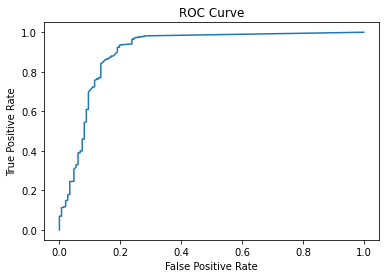

In [48]:
# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predicted_probs = outputs.numpy()
    predicted_labels = (predicted_probs > 0.5).astype(int)
    accuracy_nn = (predicted_labels == y_test_tensor.numpy().reshape(-1, 1)).mean()
    print(f'Test Accuracy: {accuracy_nn:.4f}')

    
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predicted_probs = outputs.numpy()
    predicted_labels = (predicted_probs > 0.5).astype(int)
    true_labels = y_test_tensor.numpy().reshape(-1, 1)

    # Calculate precision
    precision_nn = precision_score(true_labels, predicted_labels)

    # Calculate recall
    recall_nn = recall_score(true_labels, predicted_labels)

    # Calculate F1-score
    f1_nn = f1_score(true_labels, predicted_labels)

    # Calculate AUC-ROC
    auc_roc_nn = roc_auc_score(true_labels, predicted_probs)

    # Get ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    
    # Run time
    t0=time.time()
    time_taken_nn = time.time()-t0

    
print(f"Precision_nn: {precision_nn:.4f}")
print(f"Recall_nn: {recall_nn:.4f}")
print(f"F1-score_nn: {f1_nn:.4f}")
print(f"AUC-ROC_nn: {auc_roc_nn:.4f}")
print("Time taken_nn = {}".format(time_taken_nn))

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


## Random Forest

Precision_rf: 0.9852
Recall_rf: 0.9816
F1-score_rr: 0.9834
AUC-ROC_rf: 0.9102
Accuracy_rf: 0.9685
Time taken_rf = 2.765655517578125e-05


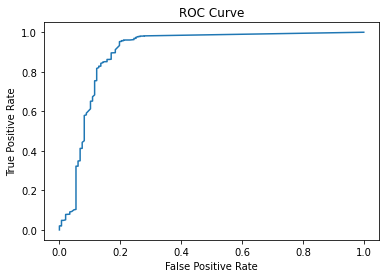

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have your input features (X) and target variable (y) ready
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the Random Forest classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy_rf = accuracy_score(y_test, y_pred)

# Calculate precision
precision_rf = precision_score(y_test, y_pred)

# Calculate recall
recall_rf = recall_score(y_test, y_pred)

# Calculate F1-score
f1_rf = f1_score(y_test, y_pred)

# Calculate AUC-ROC
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]  # Assuming your model provides probabilities for positive class
auc_roc_rf = roc_auc_score(y_test, y_pred_proba)

# Run time
t0=time.time()
time_taken_rf = time.time()-t0
#time_taken_rf =int(round(time_taken_rf))


print(f"Precision_rf: {precision_rf:.4f}")
print(f"Recall_rf: {recall_rf:.4f}")
print(f"F1-score_rr: {f1_rf:.4f}")
print(f"AUC-ROC_rf: {auc_roc_rf:.4f}")
print(f"Accuracy_rf: {accuracy_rf:.4f}")
print("Time taken_rf = {}".format(time_taken_rf))



plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [19]:
# Create lists for the metrics
#metrics = ['Accuracy', 'AUC-ROC']#, 'Time']
#model1_metrics = [accuracy_nn, auc_roc_nn]#, time_taken_nn]
#model2_metrics = [accuracy_rf, auc_roc_rf]#, time_taken_rr]

# Plot the metrics
#plt.figure(figsize=(10, 6))
#plt.bar(metrics, model1_metrics, width=0.35, label='Neural Network', align='center', alpha=0.8)
#plt.bar(metrics, model2_metrics, width=0.35, label='Random Forest', align='edge', alpha=0.8)
#plt.xlabel('Metrics')
#plt.ylabel('Values')
#plt.title('Comparison of Evaluation Metrics: Neural Network vs. Random Forest')
#plt.legend()
#plt.show()


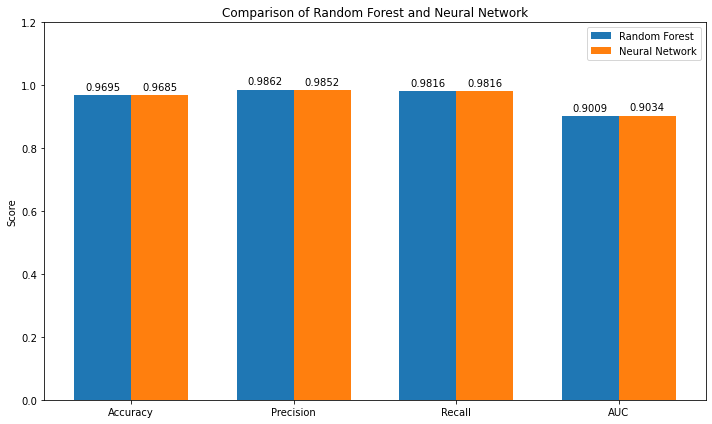

In [20]:
# Create a bar plot for comparison
labels = ['Accuracy', 'Precision', 'Recall', 'AUC']
RF_scores = [accuracy_rf, precision_rf, recall_rf,  auc_roc_rf]
NN_scores = [accuracy_nn, precision_nn, recall_nn,  auc_roc_nn]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, RF_scores, width, label='Random Forest')
rects2 = ax.bar(x + width/2, NN_scores, width, label='Neural Network')

ax.set_ylabel('Score')
ax.set_title('Comparison of Random Forest and Neural Network')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 1.2)
plt.tight_layout()
plt.show()

# TAMALE

In [239]:
# Load the dataset
data= pd.read_csv('TAMALE.csv')
df = pd.DataFrame(data)
df.head()

,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches)
0,1973-01-18,83,97.0,NaN,NaN
1,1973-01-22,87,NaN,NaN,NaN
2,1973-01-30,88,99.0,NaN,NaN
3,1973-02-03,93,100.0,NaN,NaN
4,1973-02-04,88,102.0,75.0,NaN


In [240]:
df.describe()

,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches)
count,4423.000000,2022.000000,2730.000000,1177.000000
mean,84.394529,94.489614,74.217949,0.289040
std,5.031618,6.381461,5.095185,0.588885
min,67.000000,75.000000,51.000000,0.000000
25%,81.000000,90.000000,72.000000,0.000000
50%,84.000000,95.000000,74.000000,0.020000
75%,88.000000,99.000000,77.000000,0.310000
max,101.000000,120.000000,89.000000,5.550000


In [241]:

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' column as the index
df = df.set_index('Date')

# Create a new DataFrame with a complete date range
complete_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
complete_df = pd.DataFrame(index=complete_dates)

# Merge original DataFrame with complete DataFrame
merged_df = complete_df.merge(df, left_index=True, right_index=True, how='left')

# Forward fill missing values
#filled_df = merged_df.fillna(method='ffill')

# Reset the index
merged_df = merged_df.reset_index()

# Rename columns
merged_df.columns = ['Date', 'TAVG (Degrees Fahrenheit)','TMAX (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)','PRCP (Inches)']

# Output the filled DataFrame
#print(merged_df)
#merged_df.shape
tamale=merged_df
tamale.shape
tamale.head()



#Changing strings to float
tamale['TAVG (Degrees Fahrenheit)'] = tamale['TAVG (Degrees Fahrenheit)'].astype(float)
tamale['TMAX (Degrees Fahrenheit)'] = tamale['TMAX (Degrees Fahrenheit)'].astype(float)
tamale['TMIN (Degrees Fahrenheit)'] = tamale['TMIN (Degrees Fahrenheit)'].astype(float)
tamale['PRCP (Inches)']=tamale['PRCP (Inches)'].astype(float)



#kumasi.head()

df_copy = tamale.copy()
#delete date
column_to_delete = ['TAVG (Degrees Fahrenheit)','TMAX (Degrees Fahrenheit)','TMIN (Degrees Fahrenheit)']
df_copy.drop(columns=column_to_delete, inplace=True)
#df_copy.tail(70)


# Set values to 0 for rows with months 11, 12, 01, 02, and 03
df_copy.loc[df_copy['Date'].dt.month.isin([11, 12, 1, 2]), 'PRCP (Inches)'] = 0
#df_copy.tail(70)


del tamale['PRCP (Inches)']
#kumasi.head()
#kumasi.tail(70)

tamale = pd.merge(tamale, df_copy, on='Date')


# Perform first differencing for Variable1 and Variable2
#kumasi['AVG_TEMP_D_CEL_diff'] = kumasi['AVG_TEMP_D_CEL'].diff()
#kumasi['MAX_TEMP_D_CEL_diff'] = kumasi['MAX_TEMP_D_CEL'].diff()
#kumasi['MIN_TEMP_D_CEL_diff'] = kumasi['MIN_TEMP_D_CEL'].diff()
#kumasi['PRCP (mm)_diff'] = kumasi['PRCP (mm)'].diff()

# Output the differenced dataset
#print(df)


# Impute categorical var with Mode
tamale['MIN_TEMP_DF'] = tamale['TMIN (Degrees Fahrenheit)'].fillna(tamale['TMIN (Degrees Fahrenheit)'].mode()[0])
tamale['MAX_TEMP_DF'] = tamale['TMAX (Degrees Fahrenheit)'].fillna(tamale['TMAX (Degrees Fahrenheit)'].mode()[0])
tamale['AVG_TEMP_DF'] = tamale['TAVG (Degrees Fahrenheit)'].fillna(tamale['TAVG (Degrees Fahrenheit)'].mode()[0])
tamale['PRCP (In)'] = tamale['PRCP (Inches)'].fillna(tamale['PRCP (Inches)'].mode()[0])


import warnings
warnings.filterwarnings("ignore")






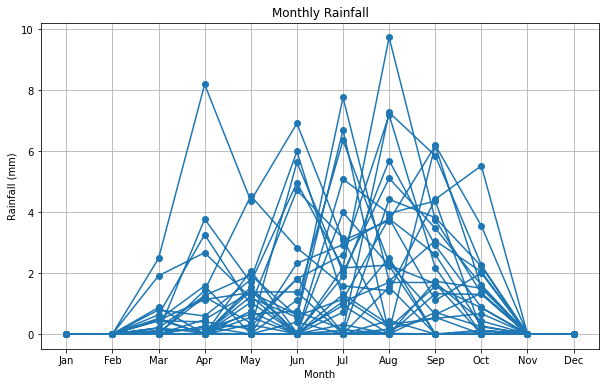

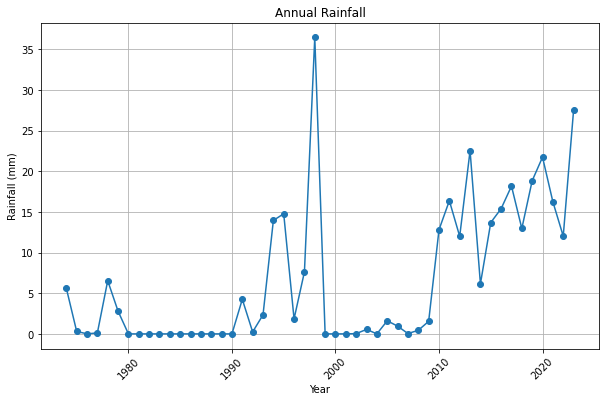

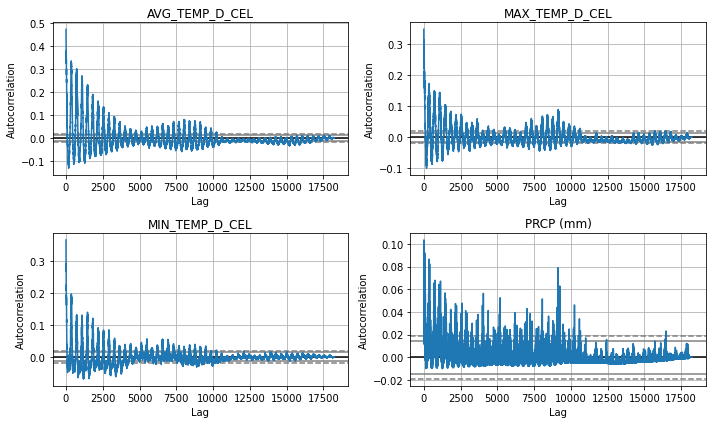

AVG_TEMP_D_CEL    0.473732
MAX_TEMP_D_CEL    0.347040
MIN_TEMP_D_CEL    0.368042
PRCP (mm)         0.028204
dtype: float64


<AxesSubplot:>

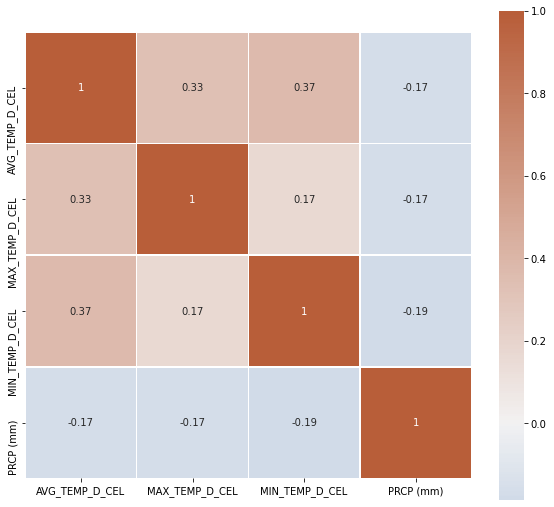

In [242]:

#delete date
#column_to_delete = ['Date']
#kumasi.drop(columns=column_to_delete, inplace=True)



#Chaning temp. to degrees and iches to mm
tamale["AVG_TEMP_D_CEL"] = (tamale["AVG_TEMP_DF"] - 32) * 5/9
tamale["MAX_TEMP_D_CEL"] = (tamale["MAX_TEMP_DF"] - 32) * 5/9
tamale["MIN_TEMP_D_CEL"] = (tamale["MIN_TEMP_DF"] - 32) * 5/9
tamale["PRCP (mm)"]=(tamale["PRCP (In)"])*25.4



# Assuming you have a DataFrame with the daily rainfall data
# Assuming the DataFrame is named 'df' and has a 'Date' column for dates and a 'Rainfall' column for daily rainfall values

# Convert the 'Date' column to a datetime object
tamale['Date'] = pd.to_datetime(tamale['Date'])

# Set the 'Date' column as the DataFrame index
tamale.set_index('Date', inplace=True)

# Resample the data to monthly and annual rainfall
monthly_rainfall = tamale['PRCP (In)'].resample('M').sum()
annual_rainfall = tamale['PRCP (In)'].resample('Y').sum()

# Plot monthly rainfall
#plt.figure(figsize=(10, 6))
#plt.plot(monthly_rainfall.index, monthly_rainfall.values, marker='o')
#plt.xlabel('Date')
#plt.ylabel('Rainfall (mm)')
#plt.title('Monthly Rainfall')
#plt.xticks(rotation=45)
#plt.grid(True)
#plt.show()

# Plot monthly rainfall
plt.figure(figsize=(10, 6))
plt.plot(monthly_rainfall.index.month, monthly_rainfall.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Rainfall (mm)')
plt.title('Monthly Rainfall')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

# Plot annual rainfall
plt.figure(figsize=(10, 6))
plt.plot(annual_rainfall.index, annual_rainfall.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.title('Annual Rainfall')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()





# Delete unwanted columns
delete = ['TAVG (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)','TMIN (Degrees Fahrenheit)','PRCP (Inches)','MIN_TEMP_DF', 'MAX_TEMP_DF', 'AVG_TEMP_DF', 'PRCP (In)'  ]
tamale.drop(columns=delete, inplace=True)

#delete = ['MIN_TEMP_DF', 'MAX_TEMP_DF', 'AVG_TEMP_DF', 'PRCP (In)'  ]
#Kumasi.drop(columns=delete, inplace=True)
                                     
                                      
                                      
tamale=tamale.round(2)


tamale = pd.DataFrame(tamale)

# Plot autocorrelation for each variable
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
axes = axes.flatten()

for i, col in enumerate(tamale.columns):
    pd.plotting.autocorrelation_plot(tamale[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


autocorr_results = tamale.apply(lambda x: x.autocorr())

# Output autocorrelation results
print(autocorr_results)


corr = tamale.corr()
#mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})


In [243]:
tamale.head()

,AVG_TEMP_D_CEL,MAX_TEMP_D_CEL,MIN_TEMP_D_CEL,PRCP (mm)
Date,,,,
1973-01-18,28.33,36.11,24.44,0.0
1973-01-19,28.33,37.22,24.44,0.0
1973-01-20,28.33,37.22,24.44,0.0
1973-01-21,28.33,37.22,24.44,0.0
1973-01-22,30.56,37.22,24.44,0.0


In [244]:
tamale.describe()

,AVG_TEMP_D_CEL,MAX_TEMP_D_CEL,MIN_TEMP_D_CEL,PRCP (mm)
count,18245.000000,18245.000000,18245.000000,18245.000000
mean,28.518626,36.942539,24.292483,0.457161
std,1.415973,1.417737,1.149835,4.042406
min,19.440000,23.890000,10.560000,0.000000
25%,28.330000,37.220000,24.440000,0.000000
50%,28.330000,37.220000,24.440000,0.000000
75%,28.330000,37.220000,24.440000,0.000000
max,38.330000,48.890000,31.670000,140.970000


In [245]:
def convert_column_to_binary(data, column_name, threshold):
    data[column_name] = data[column_name].apply(lambda x: 1 if x >= threshold else 0)
    return data

data = tamale

threshold = 0.8
column_name = 'PRCP (mm)'

data = convert_column_to_binary(data, column_name, threshold)

<function matplotlib.pyplot.show(close=None, block=None)>

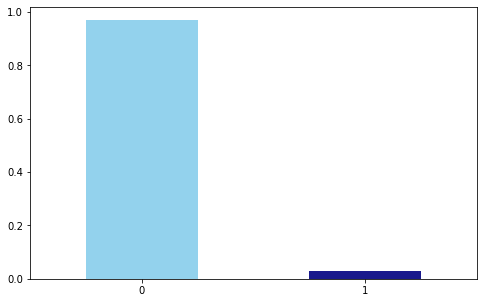

In [246]:
fig = plt.figure(figsize = (8,5))
data['PRCP (mm)'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.show

In [247]:
# Separate features (X) and target variable (y)
X = data.drop('PRCP (mm)', axis=1)  # Adjust 'target_variable' with the name of your target variable column
y = data['PRCP (mm)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine X_train and y_train into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Separate the majority and minority classes
majority_class = train_data[train_data['PRCP (mm)'] == 0]
minority_class = train_data[train_data['PRCP (mm)'] == 1]

# Upsample the minority class
minority_upsampled = resample(minority_class,
                              replace=True,  # Sample with replacement
                              n_samples=len(majority_class),  # Match the majority class samples
                              random_state=42)

# Downsample the majority class
majority_downsampled = resample(majority_class,
                                replace=False,  # No replacement
                                n_samples=len(minority_class),  # Match the minority class samples
                                random_state=42)

# Combine the upsampled minority class with the downsampled majority class
balanced_data = pd.concat([majority_downsampled, minority_upsampled])
tamale=balanced_data



In [248]:

# Split the data into input features (X) and target variable (y)
X = tamale.drop('PRCP (mm)', axis=1)  # Assuming 'rainfall_occurrence' is the target variable
y = tamale['PRCP (mm)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the input features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


## Neural Network

In [249]:
class RainfallModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RainfallModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Define the model architecture and hyperparameters
input_size = X_train_tensor.shape[1]
hidden_size = 64
model = RainfallModel(input_size, hidden_size)


In [250]:
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [251]:
# Set the number of training epochs
num_epochs = 1000

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for every few epochs
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/1000], Loss: 0.4472
Epoch [10/1000], Loss: 0.2438
Epoch [15/1000], Loss: 0.1610
Epoch [20/1000], Loss: 0.1300
Epoch [25/1000], Loss: 0.1221
Epoch [30/1000], Loss: 0.1117
Epoch [35/1000], Loss: 0.1117
Epoch [40/1000], Loss: 0.1070
Epoch [45/1000], Loss: 0.1106
Epoch [50/1000], Loss: 0.1081
Epoch [55/1000], Loss: 0.1057
Epoch [60/1000], Loss: 0.1110
Epoch [65/1000], Loss: 0.1091
Epoch [70/1000], Loss: 0.1076
Epoch [75/1000], Loss: 0.1068
Epoch [80/1000], Loss: 0.1062
Epoch [85/1000], Loss: 0.1054
Epoch [90/1000], Loss: 0.1049
Epoch [95/1000], Loss: 0.1044
Epoch [100/1000], Loss: 0.1039
Epoch [105/1000], Loss: 0.1035
Epoch [110/1000], Loss: 0.1031
Epoch [115/1000], Loss: 0.1028
Epoch [120/1000], Loss: 0.1024
Epoch [125/1000], Loss: 0.1021
Epoch [130/1000], Loss: 0.1090
Epoch [135/1000], Loss: 0.1088
Epoch [140/1000], Loss: 0.1085
Epoch [145/1000], Loss: 0.1083
Epoch [150/1000], Loss: 0.1081
Epoch [155/1000], Loss: 0.1079
Epoch [160/1000], Loss: 0.1078
Epoch [165/1000], Loss: 0.10

Test Accuracy: 0.9846
Precision_nn: 0.9936
Recall_nn: 0.9904
F1-score_nn: 0.9920
AUC-ROC_nn: 0.9305
Time taken_nn = 4.76837158203125e-07


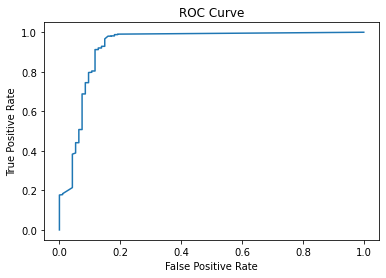

In [252]:
# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predicted_probs = outputs.numpy()
    predicted_labels = (predicted_probs > 0.5).astype(int)
    accuracy_nn = (predicted_labels == y_test_tensor.numpy().reshape(-1, 1)).mean()
    print(f'Test Accuracy: {accuracy_nn:.4f}')

    
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predicted_probs = outputs.numpy()
    predicted_labels = (predicted_probs > 0.5).astype(int)
    true_labels = y_test_tensor.numpy().reshape(-1, 1)

    # Calculate precision
    precision_nn = precision_score(true_labels, predicted_labels)

    # Calculate recall
    recall_nn = recall_score(true_labels, predicted_labels)

    # Calculate F1-score
    f1_nn = f1_score(true_labels, predicted_labels)

    # Calculate AUC-ROC
    auc_roc_nn = roc_auc_score(true_labels, predicted_probs)

    # Get ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    
    # Run time
    t0=time.time()
    time_taken_nn = time.time()-t0

    
print(f"Precision_nn: {precision_nn:.4f}")
print(f"Recall_nn: {recall_nn:.4f}")
print(f"F1-score_nn: {f1_nn:.4f}")
print(f"AUC-ROC_nn: {auc_roc_nn:.4f}")
print("Time taken_nn = {}".format(time_taken_nn))

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


## Random Forest

Precision_rf: 0.9943
Recall_rf: 0.9904
F1-score_rr: 0.9924
AUC-ROC_rf: 0.9422
Accuracy_rf: 0.9853
Time taken_rf = 2.86102294921875e-05


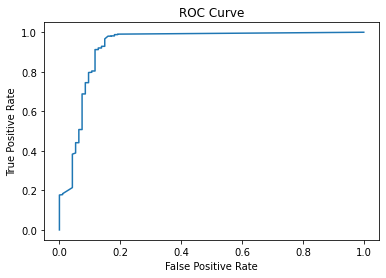

In [253]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have your input features (X) and target variable (y) ready
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy_rf = accuracy_score(y_test, y_pred)

# Calculate precision
precision_rf = precision_score(y_test, y_pred)

# Calculate recall
recall_rf = recall_score(y_test, y_pred)

# Calculate F1-score
f1_rf = f1_score(y_test, y_pred)

# Calculate AUC-ROC
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]  # Assuming your model provides probabilities for positive class
auc_roc_rf = roc_auc_score(y_test, y_pred_proba)

# Run time
t0=time.time()
time_taken_rf = time.time()-t0
#time_taken_rf =int(round(time_taken_rr))


print(f"Precision_rf: {precision_rf:.4f}")
print(f"Recall_rf: {recall_rf:.4f}")
print(f"F1-score_rr: {f1_rf:.4f}")
print(f"AUC-ROC_rf: {auc_roc_rf:.4f}")
print(f"Accuracy_rf: {accuracy_rf:.4f}")
print("Time taken_rf = {}".format(time_taken_rf))



plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


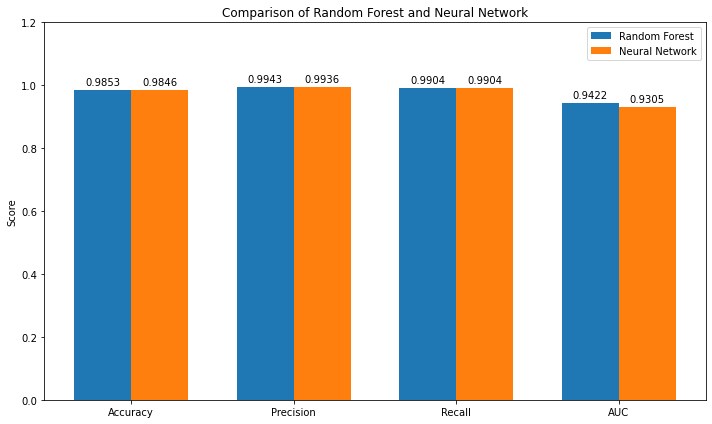

In [254]:
# Create a bar plot for comparison
labels = ['Accuracy', 'Precision', 'Recall',  'AUC']
RF_scores = [accuracy_rf, precision_rf, recall_rf,  auc_roc_rf]
NN_scores = [accuracy_nn, precision_nn, recall_nn,  auc_roc_nn]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, RF_scores, width, label='Random Forest')
rects2 = ax.bar(x + width/2, NN_scores, width, label='Neural Network')

ax.set_ylabel('Score')
ax.set_title('Comparison of Random Forest and Neural Network')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 1.2)
plt.tight_layout()
plt.show()